In [1]:
#!pip install soundfile torchaudio

In [2]:
import os
from math import inf
import torch, torchaudio
from torch import nn
from tqdm import tqdm
import torch.nn.functional as F
from torchvision import transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from plot_audio import plot_waveform, plot_specgram

In [3]:
torchaudio.info

<function torchaudio._backend.utils.get_info_func.<locals>.info(uri: Union[BinaryIO, str, os.PathLike], format: Optional[str] = None, buffer_size: int = 4096, backend: Optional[str] = None) -> torchaudio._backend.common.AudioMetaData>

In [4]:
wav_file = 'datasets/audio_data/set_a/extrahls__201101070953.wav'
waveform, sr = torchaudio.load(wav_file)

C:\Users\praveenchakra.bh\AppData\Local\Programs\Python\Python39\lib\site-packages\torchaudio\_backend\utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(


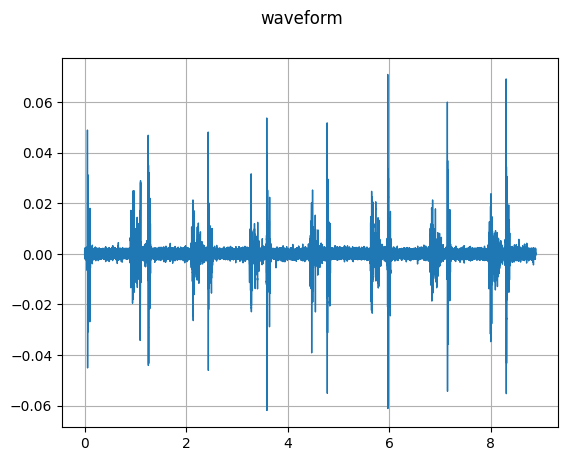

In [5]:
plot_waveform(waveform, sr)

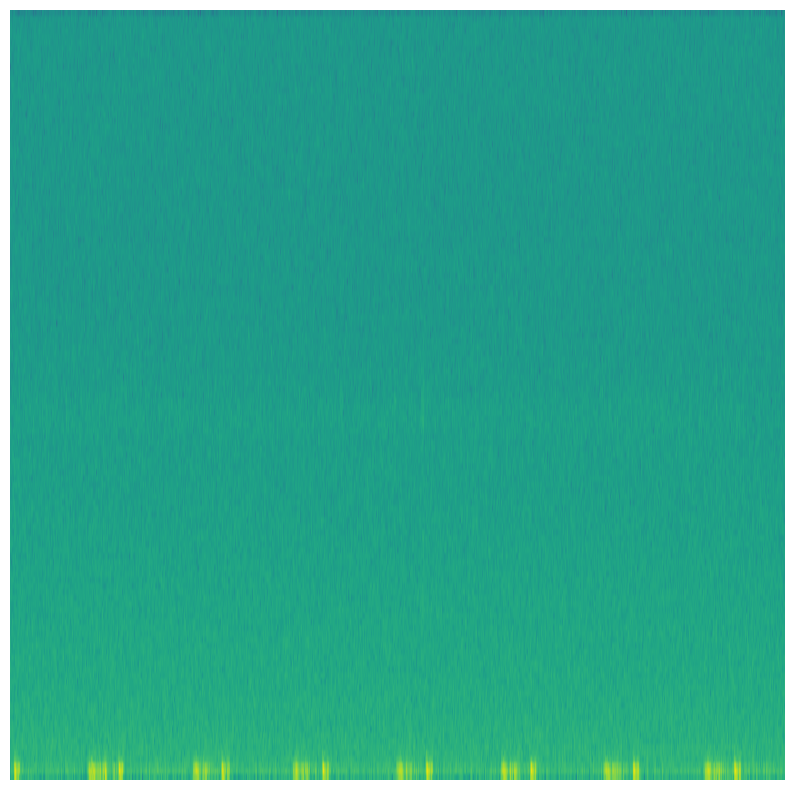

In [6]:
plot_specgram(waveform, sr)

In [7]:
# path = "datasets/audio_data/images"
# wave_path = "datasets/audio_data"

# for folder in os.listdir(wave_path):
#     audio_folder = os.path.join(wave_path, folder)
#     if os.path.isdir(audio_folder) and 'images' not in audio_folder:
#         for filename in tqdm(os.listdir(audio_folder)):
#             file_path = os.path.join(audio_folder, filename)
#             name_parts = filename.split("_")
#             folder_name = name_parts[0]
#             if "set_a" in audio_folder:
#                 file_name = filename.split("_")[-1].split(".")[0]
#             else:
#                 file_name = "_".join(name_parts[-3:]).split(".")[0]
#             complete_folder_name = os.path.join(path, folder_name)
#             os.makedirs(complete_folder_name, exist_ok=True)
#             waveform, sr = torchaudio.load(file_path)
#             plot_specgram(waveform, sr,file_path=os.path.join(complete_folder_name, file_name + ".jpg"))

In [8]:
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [9]:
dataset = datasets.ImageFolder("datasets/audio_data/images",  transform = preprocess)

In [10]:
train_size, test_size = 0.8, 0.2

In [11]:
from torch.utils.data import random_split

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

In [12]:
len(train_dataset), len(test_dataset)

(664, 165)

In [13]:
train_dataset_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_dataset_loader = DataLoader(test_dataset, batch_size=1282, shuffle=False)

In [14]:
dataset.class_to_idx

{'Aunlabelledtest': 0,
 'Bunlabelledtest': 1,
 'artifact': 2,
 'extrahls': 3,
 'extrastole': 4,
 'murmur': 5,
 'normal': 6}

In [15]:
NUM_CLASSES = len(list(dataset.class_to_idx))
print(NUM_CLASSES)

7


In [16]:
classes = list(dataset.class_to_idx)
print(classes)

['Aunlabelledtest', 'Bunlabelledtest', 'artifact', 'extrahls', 'extrastole', 'murmur', 'normal']


In [17]:
model = nn.Sequential(
    nn.Conv2d(3, 3, kernel_size=(3, 3), padding=1, padding_mode="reflect"), 
    nn.BatchNorm2d(3), 
    nn.ReLU(),
    nn.MaxPool2d(3, 3),
    nn.Conv2d(3, 6, kernel_size=(3, 3), padding=1, padding_mode="reflect"),
    nn.BatchNorm2d(6),
    nn.ReLU(),
    nn.MaxPool2d(3, 3),
    nn.Conv2d(6, 12, kernel_size=(3, 3), padding=1, padding_mode="reflect"), 
    nn.BatchNorm2d(12),
    nn.Flatten(),
    nn.Linear(6912, 1024),
    nn.Dropout(0.2),
    nn.Linear(1024, 128),
    nn.Dropout(0.2),
    nn.Linear(128, 7)
)

In [18]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)

In [19]:
model.to("cuda")

Sequential(
  (0): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
  (1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
  (5): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU()
  (7): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (8): Conv2d(6, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
  (9): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): Flatten(start_dim=1, end_dim=-1)
  (11): Linear(in_features=6912, out_features=1024, bias=True)
  (12): Dropout(p=0.2, inplace=False)
  (13): Linear(in_features=1024, out_features=128, bias=True)
  (14): Dropout(p=0.2, inplace=False)
  (15): Linear(

In [20]:
for x, y in train_dataset_loader:
    print(x.shape, y.reshape(-1, 1).shape, y)
    break

torch.Size([128, 3, 224, 224]) torch.Size([128, 1]) tensor([6, 6, 1, 0, 6, 1, 6, 5, 6, 6, 1, 0, 5, 6, 5, 5, 1, 6, 2, 1, 4, 6, 5, 6,
        5, 5, 5, 2, 1, 6, 6, 6, 1, 1, 6, 1, 6, 1, 1, 1, 1, 1, 6, 1, 6, 1, 6, 1,
        6, 5, 1, 3, 5, 0, 4, 5, 5, 6, 6, 6, 5, 1, 6, 1, 4, 0, 3, 5, 1, 6, 0, 1,
        6, 6, 6, 0, 6, 1, 1, 6, 6, 6, 6, 6, 5, 0, 6, 2, 6, 6, 5, 1, 6, 0, 1, 2,
        5, 0, 6, 5, 6, 4, 1, 4, 6, 1, 1, 6, 5, 5, 1, 4, 6, 0, 1, 6, 4, 6, 6, 6,
        1, 6, 0, 2, 5, 6, 1, 6])


In [21]:
early_stopping = 0
old_loss = inf
for i in range(100):
    print(f"[] Epochs: {i+1}")
    total_loss = 0
    model.train()
    for x, y in tqdm(train_dataset_loader):
        optimizer.zero_grad()
        outputs = model(x.to("cuda"))
        y = F.one_hot(y, num_classes=7).type(torch.float32).to("cuda")
        loss = loss_fn(outputs, y)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
    loss_value = total_loss
    if loss_value < old_loss:
        old_loss = loss_value
        early_stopping = 0
    else:
        early_stopping += 1
    if early_stopping > 2:
        print("Early stopping triggered")
        break
    print(total_loss)

[] Epochs: 1


100%|████████████████████████| 6/6 [00:06<00:00,  1.08s/it]


9.83205270767212
[] Epochs: 2


100%|████████████████████████| 6/6 [00:06<00:00,  1.08s/it]


8.481226444244385
[] Epochs: 3


100%|████████████████████████| 6/6 [00:06<00:00,  1.13s/it]


7.950796842575073
[] Epochs: 4


100%|████████████████████████| 6/6 [00:06<00:00,  1.13s/it]


7.647060513496399
[] Epochs: 5


100%|████████████████████████| 6/6 [00:06<00:00,  1.14s/it]


7.96232533454895
[] Epochs: 6


100%|████████████████████████| 6/6 [00:06<00:00,  1.13s/it]


7.281741976737976
[] Epochs: 7


100%|████████████████████████| 6/6 [00:06<00:00,  1.13s/it]


7.002800822257996
[] Epochs: 8


100%|████████████████████████| 6/6 [00:06<00:00,  1.15s/it]


6.900023102760315
[] Epochs: 9


100%|████████████████████████| 6/6 [00:06<00:00,  1.11s/it]


6.874077558517456
[] Epochs: 10


100%|████████████████████████| 6/6 [00:06<00:00,  1.07s/it]


6.750107288360596
[] Epochs: 11


100%|████████████████████████| 6/6 [00:06<00:00,  1.06s/it]


6.7515363693237305
[] Epochs: 12


100%|████████████████████████| 6/6 [00:06<00:00,  1.07s/it]


6.352704346179962
[] Epochs: 13


100%|████████████████████████| 6/6 [00:06<00:00,  1.05s/it]


6.063540995121002
[] Epochs: 14


100%|████████████████████████| 6/6 [00:06<00:00,  1.10s/it]


6.060484170913696
[] Epochs: 15


100%|████████████████████████| 6/6 [00:06<00:00,  1.06s/it]


6.083981931209564
[] Epochs: 16


100%|████████████████████████| 6/6 [00:06<00:00,  1.05s/it]


5.607663929462433
[] Epochs: 17


100%|████████████████████████| 6/6 [00:06<00:00,  1.15s/it]


5.594527959823608
[] Epochs: 18


100%|████████████████████████| 6/6 [00:06<00:00,  1.09s/it]


5.629719913005829
[] Epochs: 19


100%|████████████████████████| 6/6 [00:06<00:00,  1.07s/it]


5.381258130073547
[] Epochs: 20


100%|████████████████████████| 6/6 [00:06<00:00,  1.06s/it]


5.1163933873176575
[] Epochs: 21


100%|████████████████████████| 6/6 [00:06<00:00,  1.04s/it]


5.108499586582184
[] Epochs: 22


100%|████████████████████████| 6/6 [00:06<00:00,  1.09s/it]


4.959856331348419
[] Epochs: 23


100%|████████████████████████| 6/6 [00:06<00:00,  1.09s/it]


4.677222967147827
[] Epochs: 24


100%|████████████████████████| 6/6 [00:07<00:00,  1.29s/it]


4.8214810490608215
[] Epochs: 25


100%|████████████████████████| 6/6 [00:07<00:00,  1.27s/it]


4.6350215673446655
[] Epochs: 26


100%|████████████████████████| 6/6 [00:06<00:00,  1.14s/it]


4.152467608451843
[] Epochs: 27


100%|████████████████████████| 6/6 [00:07<00:00,  1.31s/it]


4.186977744102478
[] Epochs: 28


100%|████████████████████████| 6/6 [00:07<00:00,  1.32s/it]


4.056307315826416
[] Epochs: 29


100%|████████████████████████| 6/6 [00:07<00:00,  1.20s/it]


3.9191659688949585
[] Epochs: 30


100%|████████████████████████| 6/6 [00:07<00:00,  1.22s/it]


3.7939571142196655
[] Epochs: 31


100%|████████████████████████| 6/6 [00:06<00:00,  1.16s/it]


3.991141676902771
[] Epochs: 32


100%|████████████████████████| 6/6 [00:07<00:00,  1.28s/it]


3.703118681907654
[] Epochs: 33


100%|████████████████████████| 6/6 [00:07<00:00,  1.17s/it]


3.413088619709015
[] Epochs: 34


100%|████████████████████████| 6/6 [00:07<00:00,  1.17s/it]


3.202334076166153
[] Epochs: 35


100%|████████████████████████| 6/6 [00:07<00:00,  1.26s/it]


3.091059237718582
[] Epochs: 36


100%|████████████████████████| 6/6 [00:07<00:00,  1.23s/it]


3.2665331959724426
[] Epochs: 37


100%|████████████████████████| 6/6 [00:07<00:00,  1.19s/it]


3.211302399635315
[] Epochs: 38


100%|████████████████████████| 6/6 [00:07<00:00,  1.21s/it]


2.973953664302826
[] Epochs: 39


100%|████████████████████████| 6/6 [00:06<00:00,  1.16s/it]


3.120775818824768
[] Epochs: 40


100%|████████████████████████| 6/6 [00:07<00:00,  1.20s/it]


2.787924349308014
[] Epochs: 41


100%|████████████████████████| 6/6 [00:07<00:00,  1.22s/it]


2.694142162799835
[] Epochs: 42


100%|████████████████████████| 6/6 [00:06<00:00,  1.12s/it]


2.7827210426330566
[] Epochs: 43


100%|████████████████████████| 6/6 [00:06<00:00,  1.09s/it]


2.511596232652664
[] Epochs: 44


100%|████████████████████████| 6/6 [00:07<00:00,  1.22s/it]


2.388873875141144
[] Epochs: 45


100%|████████████████████████| 6/6 [00:07<00:00,  1.28s/it]


2.4476179480552673
[] Epochs: 46


100%|████████████████████████| 6/6 [00:07<00:00,  1.19s/it]


2.5929336547851562
[] Epochs: 47


100%|████████████████████████| 6/6 [00:06<00:00,  1.09s/it]


2.280377298593521
[] Epochs: 48


100%|████████████████████████| 6/6 [00:06<00:00,  1.11s/it]


2.086663544178009
[] Epochs: 49


100%|████████████████████████| 6/6 [00:07<00:00,  1.18s/it]


2.174602597951889
[] Epochs: 50


100%|████████████████████████| 6/6 [00:07<00:00,  1.19s/it]


2.0402472466230392
[] Epochs: 51


100%|████████████████████████| 6/6 [00:07<00:00,  1.24s/it]


2.281367003917694
[] Epochs: 52


100%|████████████████████████| 6/6 [00:07<00:00,  1.24s/it]


1.9746370315551758
[] Epochs: 53


100%|████████████████████████| 6/6 [00:07<00:00,  1.18s/it]


1.890822947025299
[] Epochs: 54


100%|████████████████████████| 6/6 [00:07<00:00,  1.20s/it]


2.0758960247039795
[] Epochs: 55


100%|████████████████████████| 6/6 [00:07<00:00,  1.19s/it]


1.9791434109210968
[] Epochs: 56


100%|████████████████████████| 6/6 [00:07<00:00,  1.23s/it]

Early stopping triggered


In [22]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0    
    test_loss = 0
    for x, y in tqdm(test_dataset_loader):
        x = x.to("cuda")
        y = y.to("cuda") 
        outputs = model(x)
        preds = outputs.argmax(dim=1)
        correct += (preds == y).sum().item()    
        loss = loss_fn(outputs, y)
        total += y.size(0)   
        test_loss += loss.item() * y.size(0)
    accuracy = correct / total
    loss = test_loss / total
    print(f"Accuracy: {accuracy}, Test loss: {loss}")

100%|████████████████████████| 1/1 [00:01<00:00,  1.91s/it]

Accuracy: 0.3393939393939394, Test loss: 1.7725592851638794
